# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

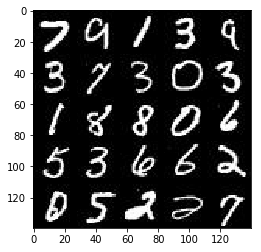

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

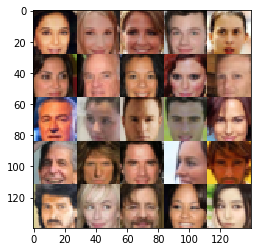

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    layer = images # 28x28x[1|3]
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Convolutions - output is 4x4x256
        for f in [64, 128, 256]:
            layer = tf.layers.conv2d(layer, f, 5, strides=2, padding='same')
            layer = leaky_relu(layer)
        # Flatten output and compute logits
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1)
        # Probability
        prob = tf.sigmoid(logits)

    return prob, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    with tf.variable_scope('generator', reuse=not is_train):
#         with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Reshape to start convolutions
        layer = tf.layers.dense(z, 3*3*512)
        layer = tf.reshape(layer, (-1, 3, 3, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = leaky_relu(layer)
        # Transposed convolutions
        for f in [256, 128]:
            layer = tf.layers.conv2d_transpose(layer, f, 5, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=is_train)
            layer = leaky_relu(layer)
        # Transposed convolution without batch_norm and activation
        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 6, strides=2, padding='valid')
        # Output squashed between -1 and 1
        output = tf.tanh(layer)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # Forward passes to generate fake image and real/fake logits
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    prob_real, logits_real = discriminator(input_real, reuse=False)
    prob_fake, logits_fake = discriminator(input_fake, reuse=True)
    # Discriminator's loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    # Generator's loss    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    d_variables = [v for v in trainable_variables if v.name.startswith('discriminator')]
    g_variables = [v for v in trainable_variables if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_variables)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_variables)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = len(data_image_mode)
    steps = 0
    
    real_images, z, lr = model_inputs(28, 28, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(real_images, z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_images: batch_images, 
                                               z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_images: batch_images, 
                                               z: batch_z, 
                                               lr: learning_rate})
                # Monitor losses
                if steps % 20 == 0:
                    d_train_loss = sess.run(d_loss, feed_dict={real_images: batch_images,
                                                               z: batch_z,
                                                               lr: learning_rate})
                    g_train_loss = sess.run(g_loss, feed_dict={real_images: batch_images,
                                                               z: batch_z,
                                                               lr: learning_rate})
                    print('Epoch {}/{}, '.format(epoch_i, epoch_count),
                          'Step {}\t'.format(steps),
                          'Discriminator loss: {:.4f}\t'.format(d_train_loss),
                          'Generator loss: {:.4f}\t'.format(g_train_loss))
                # Monitor fake images
                if steps % 100 == 0:
                    show_generator_output(sess, 36, z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2,  Step 20	 Discriminator loss: 0.8396	 Generator loss: 1.2874	
Epoch 0/2,  Step 40	 Discriminator loss: 1.1806	 Generator loss: 0.8791	
Epoch 0/2,  Step 60	 Discriminator loss: 1.4679	 Generator loss: 1.5055	
Epoch 0/2,  Step 80	 Discriminator loss: 1.0929	 Generator loss: 1.3149	
Epoch 0/2,  Step 100	 Discriminator loss: 1.0155	 Generator loss: 1.0091	


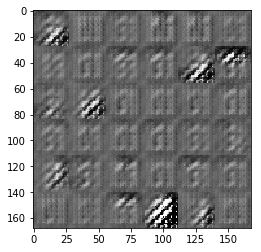

Epoch 0/2,  Step 120	 Discriminator loss: 1.5368	 Generator loss: 0.4603	
Epoch 0/2,  Step 140	 Discriminator loss: 1.2235	 Generator loss: 1.3758	
Epoch 0/2,  Step 160	 Discriminator loss: 0.9717	 Generator loss: 1.2892	
Epoch 0/2,  Step 180	 Discriminator loss: 1.0575	 Generator loss: 1.2503	
Epoch 0/2,  Step 200	 Discriminator loss: 1.0625	 Generator loss: 0.9971	


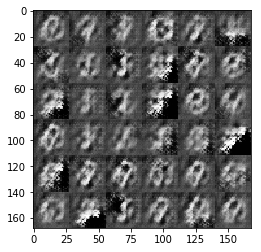

Epoch 0/2,  Step 220	 Discriminator loss: 1.2902	 Generator loss: 3.0088	
Epoch 0/2,  Step 240	 Discriminator loss: 0.8322	 Generator loss: 1.1941	
Epoch 0/2,  Step 260	 Discriminator loss: 0.9849	 Generator loss: 0.9296	
Epoch 0/2,  Step 280	 Discriminator loss: 1.3799	 Generator loss: 2.5061	
Epoch 0/2,  Step 300	 Discriminator loss: 1.1216	 Generator loss: 0.7657	


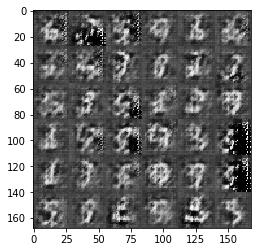

Epoch 0/2,  Step 320	 Discriminator loss: 0.8933	 Generator loss: 1.3250	
Epoch 0/2,  Step 340	 Discriminator loss: 1.2622	 Generator loss: 0.7327	
Epoch 0/2,  Step 360	 Discriminator loss: 1.2253	 Generator loss: 2.6714	
Epoch 0/2,  Step 380	 Discriminator loss: 0.6566	 Generator loss: 2.1446	
Epoch 0/2,  Step 400	 Discriminator loss: 1.3158	 Generator loss: 0.5890	


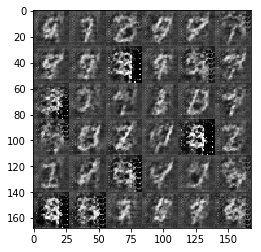

Epoch 0/2,  Step 420	 Discriminator loss: 0.9665	 Generator loss: 0.9631	
Epoch 0/2,  Step 440	 Discriminator loss: 0.8404	 Generator loss: 1.5324	
Epoch 0/2,  Step 460	 Discriminator loss: 1.0352	 Generator loss: 0.9591	
Epoch 0/2,  Step 480	 Discriminator loss: 0.8653	 Generator loss: 1.2203	
Epoch 0/2,  Step 500	 Discriminator loss: 0.8994	 Generator loss: 1.4417	


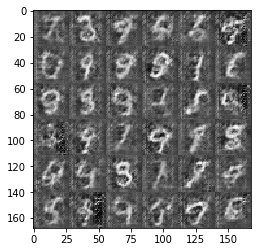

Epoch 0/2,  Step 520	 Discriminator loss: 0.8274	 Generator loss: 1.4562	
Epoch 0/2,  Step 540	 Discriminator loss: 1.0243	 Generator loss: 1.0997	
Epoch 0/2,  Step 560	 Discriminator loss: 1.6954	 Generator loss: 0.3795	
Epoch 0/2,  Step 580	 Discriminator loss: 0.8961	 Generator loss: 1.2682	
Epoch 0/2,  Step 600	 Discriminator loss: 0.7027	 Generator loss: 2.9663	


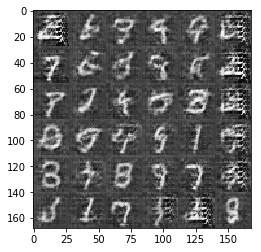

Epoch 0/2,  Step 620	 Discriminator loss: 0.7650	 Generator loss: 1.5370	
Epoch 0/2,  Step 640	 Discriminator loss: 1.3680	 Generator loss: 0.5609	
Epoch 0/2,  Step 660	 Discriminator loss: 0.8977	 Generator loss: 1.2920	
Epoch 0/2,  Step 680	 Discriminator loss: 1.0604	 Generator loss: 0.8839	
Epoch 0/2,  Step 700	 Discriminator loss: 1.2980	 Generator loss: 0.6846	


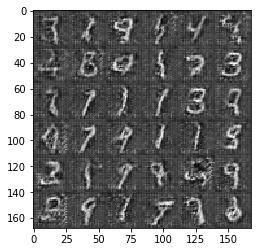

Epoch 0/2,  Step 720	 Discriminator loss: 0.7962	 Generator loss: 1.6360	
Epoch 0/2,  Step 740	 Discriminator loss: 0.9366	 Generator loss: 2.2738	
Epoch 0/2,  Step 760	 Discriminator loss: 0.9595	 Generator loss: 1.2634	
Epoch 0/2,  Step 780	 Discriminator loss: 1.4533	 Generator loss: 0.5044	
Epoch 0/2,  Step 800	 Discriminator loss: 0.5489	 Generator loss: 2.1983	


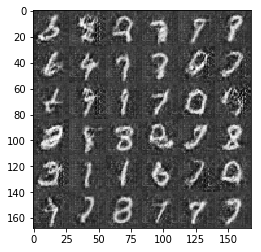

Epoch 0/2,  Step 820	 Discriminator loss: 0.6871	 Generator loss: 1.5733	
Epoch 0/2,  Step 840	 Discriminator loss: 0.5320	 Generator loss: 2.9769	
Epoch 0/2,  Step 860	 Discriminator loss: 1.3324	 Generator loss: 3.6811	
Epoch 0/2,  Step 880	 Discriminator loss: 0.4094	 Generator loss: 3.9613	
Epoch 0/2,  Step 900	 Discriminator loss: 0.6641	 Generator loss: 2.1518	


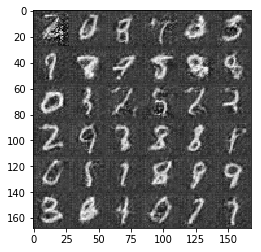

Epoch 0/2,  Step 920	 Discriminator loss: 0.6734	 Generator loss: 1.7517	
Epoch 1/2,  Step 940	 Discriminator loss: 0.7123	 Generator loss: 1.6834	
Epoch 1/2,  Step 960	 Discriminator loss: 0.8715	 Generator loss: 1.1297	
Epoch 1/2,  Step 980	 Discriminator loss: 0.7390	 Generator loss: 1.7638	
Epoch 1/2,  Step 1000	 Discriminator loss: 1.1724	 Generator loss: 4.2375	


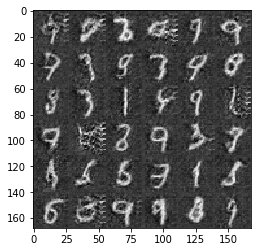

Epoch 1/2,  Step 1020	 Discriminator loss: 0.5908	 Generator loss: 2.0655	
Epoch 1/2,  Step 1040	 Discriminator loss: 0.9810	 Generator loss: 1.0071	
Epoch 1/2,  Step 1060	 Discriminator loss: 0.8275	 Generator loss: 2.5586	
Epoch 1/2,  Step 1080	 Discriminator loss: 1.0894	 Generator loss: 0.9405	
Epoch 1/2,  Step 1100	 Discriminator loss: 1.4388	 Generator loss: 0.5431	


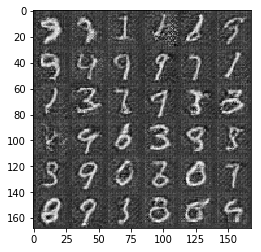

Epoch 1/2,  Step 1120	 Discriminator loss: 0.5907	 Generator loss: 6.0312	
Epoch 1/2,  Step 1140	 Discriminator loss: 0.6461	 Generator loss: 1.8077	
Epoch 1/2,  Step 1160	 Discriminator loss: 0.4233	 Generator loss: 3.7359	
Epoch 1/2,  Step 1180	 Discriminator loss: 1.3520	 Generator loss: 2.4714	
Epoch 1/2,  Step 1200	 Discriminator loss: 0.8340	 Generator loss: 1.2484	


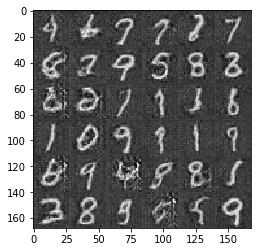

Epoch 1/2,  Step 1220	 Discriminator loss: 0.7719	 Generator loss: 1.7327	
Epoch 1/2,  Step 1240	 Discriminator loss: 0.8562	 Generator loss: 3.1840	
Epoch 1/2,  Step 1260	 Discriminator loss: 1.3084	 Generator loss: 0.7389	
Epoch 1/2,  Step 1280	 Discriminator loss: 0.5236	 Generator loss: 2.7354	
Epoch 1/2,  Step 1300	 Discriminator loss: 1.1125	 Generator loss: 0.8642	


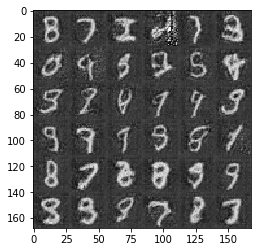

Epoch 1/2,  Step 1320	 Discriminator loss: 0.4505	 Generator loss: 3.6458	
Epoch 1/2,  Step 1340	 Discriminator loss: 1.0230	 Generator loss: 2.7037	
Epoch 1/2,  Step 1360	 Discriminator loss: 0.7221	 Generator loss: 1.7229	
Epoch 1/2,  Step 1380	 Discriminator loss: 0.4363	 Generator loss: 3.2309	
Epoch 1/2,  Step 1400	 Discriminator loss: 0.3927	 Generator loss: 4.6406	


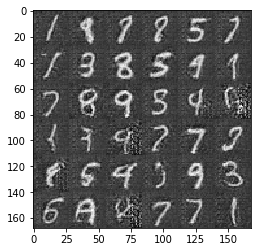

Epoch 1/2,  Step 1420	 Discriminator loss: 1.2931	 Generator loss: 4.3515	
Epoch 1/2,  Step 1440	 Discriminator loss: 0.4437	 Generator loss: 3.7669	
Epoch 1/2,  Step 1460	 Discriminator loss: 0.7684	 Generator loss: 1.7004	
Epoch 1/2,  Step 1480	 Discriminator loss: 1.2483	 Generator loss: 0.7790	
Epoch 1/2,  Step 1500	 Discriminator loss: 0.7728	 Generator loss: 1.4290	


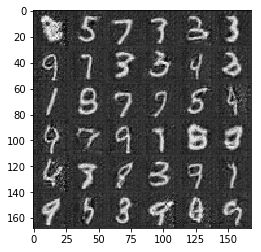

Epoch 1/2,  Step 1520	 Discriminator loss: 0.9444	 Generator loss: 1.0711	
Epoch 1/2,  Step 1540	 Discriminator loss: 0.6766	 Generator loss: 1.7358	
Epoch 1/2,  Step 1560	 Discriminator loss: 0.7322	 Generator loss: 1.5118	
Epoch 1/2,  Step 1580	 Discriminator loss: 0.4670	 Generator loss: 3.9284	
Epoch 1/2,  Step 1600	 Discriminator loss: 1.0003	 Generator loss: 0.9940	


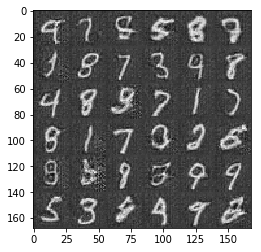

Epoch 1/2,  Step 1620	 Discriminator loss: 0.4245	 Generator loss: 4.8896	
Epoch 1/2,  Step 1640	 Discriminator loss: 0.4245	 Generator loss: 4.4902	
Epoch 1/2,  Step 1660	 Discriminator loss: 0.4970	 Generator loss: 3.2893	
Epoch 1/2,  Step 1680	 Discriminator loss: 0.4532	 Generator loss: 3.5497	
Epoch 1/2,  Step 1700	 Discriminator loss: 0.6984	 Generator loss: 1.6046	


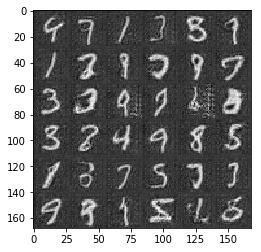

Epoch 1/2,  Step 1720	 Discriminator loss: 1.1301	 Generator loss: 0.8759	
Epoch 1/2,  Step 1740	 Discriminator loss: 0.3769	 Generator loss: 5.3116	
Epoch 1/2,  Step 1760	 Discriminator loss: 0.4975	 Generator loss: 2.7801	
Epoch 1/2,  Step 1780	 Discriminator loss: 0.3823	 Generator loss: 5.3046	
Epoch 1/2,  Step 1800	 Discriminator loss: 3.7266	 Generator loss: 2.8873	


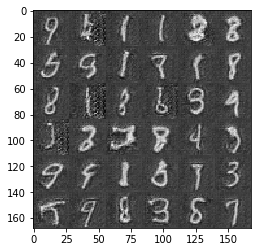

Epoch 1/2,  Step 1820	 Discriminator loss: 0.8157	 Generator loss: 1.3453	
Epoch 1/2,  Step 1840	 Discriminator loss: 0.9192	 Generator loss: 1.0139	
Epoch 1/2,  Step 1860	 Discriminator loss: 0.6776	 Generator loss: 2.3165	


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1,  Step 20	 Discriminator loss: 0.8279	 Generator loss: 1.6496	
Epoch 0/1,  Step 40	 Discriminator loss: 1.1268	 Generator loss: 1.1277	
Epoch 0/1,  Step 60	 Discriminator loss: 0.6363	 Generator loss: 2.0833	
Epoch 0/1,  Step 80	 Discriminator loss: 0.6941	 Generator loss: 1.6354	
Epoch 0/1,  Step 100	 Discriminator loss: 1.5589	 Generator loss: 0.4651	


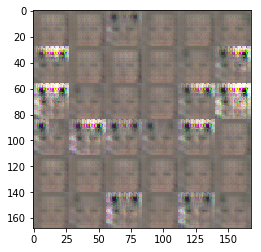

Epoch 0/1,  Step 120	 Discriminator loss: 1.0381	 Generator loss: 1.2983	
Epoch 0/1,  Step 140	 Discriminator loss: 0.9331	 Generator loss: 1.8286	
Epoch 0/1,  Step 160	 Discriminator loss: 1.1218	 Generator loss: 1.5705	
Epoch 0/1,  Step 180	 Discriminator loss: 0.9533	 Generator loss: 2.2558	
Epoch 0/1,  Step 200	 Discriminator loss: 0.9236	 Generator loss: 1.4142	


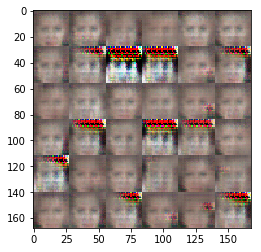

Epoch 0/1,  Step 220	 Discriminator loss: 1.0247	 Generator loss: 1.4572	
Epoch 0/1,  Step 240	 Discriminator loss: 0.9137	 Generator loss: 1.6322	
Epoch 0/1,  Step 260	 Discriminator loss: 1.0933	 Generator loss: 1.1096	
Epoch 0/1,  Step 280	 Discriminator loss: 1.1354	 Generator loss: 1.6142	
Epoch 0/1,  Step 300	 Discriminator loss: 1.0333	 Generator loss: 1.2403	


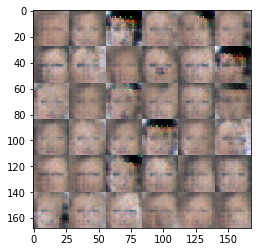

Epoch 0/1,  Step 320	 Discriminator loss: 1.3143	 Generator loss: 0.7571	
Epoch 0/1,  Step 340	 Discriminator loss: 1.1361	 Generator loss: 2.5018	
Epoch 0/1,  Step 360	 Discriminator loss: 1.1902	 Generator loss: 0.7876	
Epoch 0/1,  Step 380	 Discriminator loss: 1.3483	 Generator loss: 2.3567	
Epoch 0/1,  Step 400	 Discriminator loss: 1.1772	 Generator loss: 0.9800	


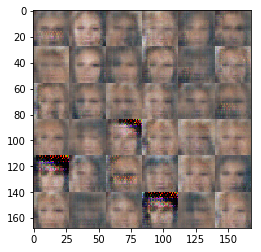

Epoch 0/1,  Step 420	 Discriminator loss: 1.0046	 Generator loss: 1.2308	
Epoch 0/1,  Step 440	 Discriminator loss: 0.9688	 Generator loss: 1.2740	
Epoch 0/1,  Step 460	 Discriminator loss: 1.3657	 Generator loss: 0.5836	
Epoch 0/1,  Step 480	 Discriminator loss: 0.9902	 Generator loss: 1.2184	
Epoch 0/1,  Step 500	 Discriminator loss: 1.0666	 Generator loss: 1.0953	


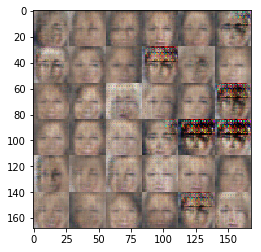

Epoch 0/1,  Step 520	 Discriminator loss: 1.0980	 Generator loss: 0.8799	
Epoch 0/1,  Step 540	 Discriminator loss: 0.9979	 Generator loss: 1.0840	
Epoch 0/1,  Step 560	 Discriminator loss: 1.2827	 Generator loss: 0.8951	
Epoch 0/1,  Step 580	 Discriminator loss: 0.8369	 Generator loss: 1.9557	
Epoch 0/1,  Step 600	 Discriminator loss: 1.1025	 Generator loss: 0.9888	


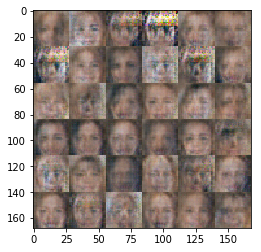

Epoch 0/1,  Step 620	 Discriminator loss: 1.0601	 Generator loss: 0.9715	
Epoch 0/1,  Step 640	 Discriminator loss: 1.8324	 Generator loss: 1.6871	
Epoch 0/1,  Step 660	 Discriminator loss: 1.1016	 Generator loss: 1.4067	
Epoch 0/1,  Step 680	 Discriminator loss: 0.9860	 Generator loss: 1.2337	
Epoch 0/1,  Step 700	 Discriminator loss: 1.7228	 Generator loss: 1.4371	


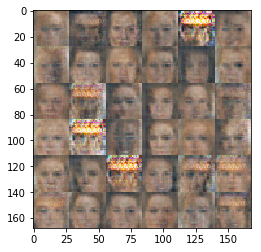

Epoch 0/1,  Step 720	 Discriminator loss: 0.9971	 Generator loss: 1.6370	
Epoch 0/1,  Step 740	 Discriminator loss: 0.8634	 Generator loss: 1.5657	
Epoch 0/1,  Step 760	 Discriminator loss: 1.0697	 Generator loss: 1.3383	
Epoch 0/1,  Step 780	 Discriminator loss: 0.9245	 Generator loss: 1.3140	
Epoch 0/1,  Step 800	 Discriminator loss: 0.9489	 Generator loss: 1.6913	


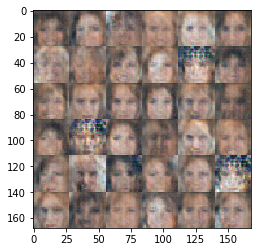

Epoch 0/1,  Step 820	 Discriminator loss: 1.1316	 Generator loss: 1.9697	
Epoch 0/1,  Step 840	 Discriminator loss: 0.4707	 Generator loss: 4.7896	
Epoch 0/1,  Step 860	 Discriminator loss: 0.9497	 Generator loss: 1.1049	
Epoch 0/1,  Step 880	 Discriminator loss: 1.3143	 Generator loss: 0.6154	
Epoch 0/1,  Step 900	 Discriminator loss: 0.8891	 Generator loss: 1.6831	


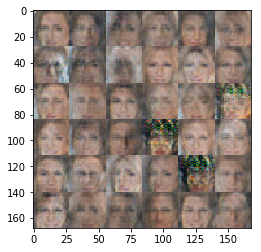

Epoch 0/1,  Step 920	 Discriminator loss: 0.9301	 Generator loss: 1.4757	
Epoch 0/1,  Step 940	 Discriminator loss: 1.4433	 Generator loss: 0.6304	
Epoch 0/1,  Step 960	 Discriminator loss: 0.9551	 Generator loss: 2.1519	
Epoch 0/1,  Step 980	 Discriminator loss: 1.1242	 Generator loss: 1.0109	
Epoch 0/1,  Step 1000	 Discriminator loss: 0.9592	 Generator loss: 1.4009	


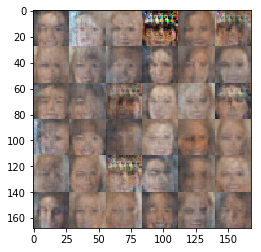

Epoch 0/1,  Step 1020	 Discriminator loss: 1.0212	 Generator loss: 0.9822	
Epoch 0/1,  Step 1040	 Discriminator loss: 0.9650	 Generator loss: 1.4853	
Epoch 0/1,  Step 1060	 Discriminator loss: 1.1126	 Generator loss: 0.9021	
Epoch 0/1,  Step 1080	 Discriminator loss: 1.3495	 Generator loss: 0.7487	
Epoch 0/1,  Step 1100	 Discriminator loss: 2.9072	 Generator loss: 2.7608	


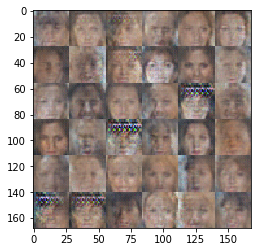

Epoch 0/1,  Step 1120	 Discriminator loss: 1.0373	 Generator loss: 1.3235	
Epoch 0/1,  Step 1140	 Discriminator loss: 1.6458	 Generator loss: 0.4535	
Epoch 0/1,  Step 1160	 Discriminator loss: 1.1400	 Generator loss: 0.9359	
Epoch 0/1,  Step 1180	 Discriminator loss: 1.1123	 Generator loss: 0.7964	
Epoch 0/1,  Step 1200	 Discriminator loss: 0.9611	 Generator loss: 1.2110	


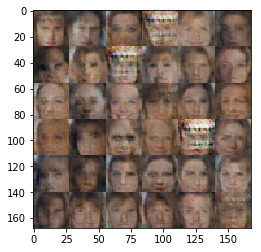

Epoch 0/1,  Step 1220	 Discriminator loss: 1.3713	 Generator loss: 0.6821	
Epoch 0/1,  Step 1240	 Discriminator loss: 0.9768	 Generator loss: 1.6694	
Epoch 0/1,  Step 1260	 Discriminator loss: 1.1010	 Generator loss: 0.9707	
Epoch 0/1,  Step 1280	 Discriminator loss: 1.1725	 Generator loss: 1.7718	
Epoch 0/1,  Step 1300	 Discriminator loss: 1.0182	 Generator loss: 1.2347	


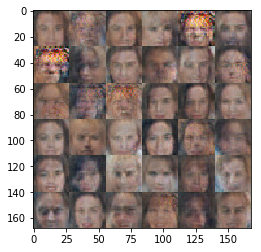

Epoch 0/1,  Step 1320	 Discriminator loss: 1.0104	 Generator loss: 1.0412	
Epoch 0/1,  Step 1340	 Discriminator loss: 1.5436	 Generator loss: 0.5849	
Epoch 0/1,  Step 1360	 Discriminator loss: 0.5271	 Generator loss: 5.8347	
Epoch 0/1,  Step 1380	 Discriminator loss: 280409.4375	 Generator loss: 2076.9463	
Epoch 0/1,  Step 1400	 Discriminator loss: 17.8860	 Generator loss: 53.0081	


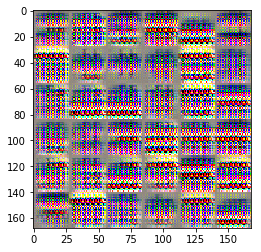

Epoch 0/1,  Step 1420	 Discriminator loss: 14.3409	 Generator loss: 59.8346	
Epoch 0/1,  Step 1440	 Discriminator loss: 12.0733	 Generator loss: 65.9163	
Epoch 0/1,  Step 1460	 Discriminator loss: 13.1765	 Generator loss: 24.0465	
Epoch 0/1,  Step 1480	 Discriminator loss: 12.0579	 Generator loss: 29.0518	
Epoch 0/1,  Step 1500	 Discriminator loss: 69.3845	 Generator loss: 148.1353	


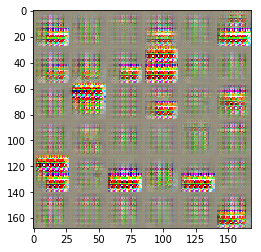

Epoch 0/1,  Step 1520	 Discriminator loss: 10.4794	 Generator loss: 8.6447	
Epoch 0/1,  Step 1540	 Discriminator loss: 11.6595	 Generator loss: 14.7256	
Epoch 0/1,  Step 1560	 Discriminator loss: 7.6848	 Generator loss: 67.9115	
Epoch 0/1,  Step 1580	 Discriminator loss: 8.0994	 Generator loss: 28.1075	
Epoch 0/1,  Step 1600	 Discriminator loss: 6.2529	 Generator loss: 23.3240	


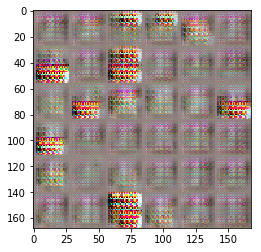

Epoch 0/1,  Step 1620	 Discriminator loss: 8.3424	 Generator loss: 60.6337	
Epoch 0/1,  Step 1640	 Discriminator loss: 17.2457	 Generator loss: 47.9420	
Epoch 0/1,  Step 1660	 Discriminator loss: 32.7002	 Generator loss: 2.7056	
Epoch 0/1,  Step 1680	 Discriminator loss: 32.1449	 Generator loss: 0.2048	
Epoch 0/1,  Step 1700	 Discriminator loss: 9.1114	 Generator loss: 6.8473	


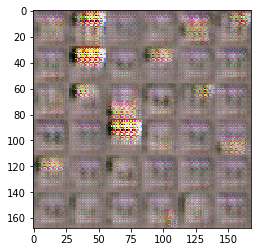

Epoch 0/1,  Step 1720	 Discriminator loss: 18.1188	 Generator loss: 1.8296	
Epoch 0/1,  Step 1740	 Discriminator loss: 25.4535	 Generator loss: 43.7493	
Epoch 0/1,  Step 1760	 Discriminator loss: 40.7865	 Generator loss: 55.7748	
Epoch 0/1,  Step 1780	 Discriminator loss: 12.5733	 Generator loss: 0.7472	
Epoch 0/1,  Step 1800	 Discriminator loss: 24.1629	 Generator loss: 0.3612	


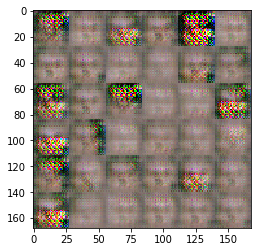

Epoch 0/1,  Step 1820	 Discriminator loss: 26.9769	 Generator loss: 35.5542	
Epoch 0/1,  Step 1840	 Discriminator loss: 12.3095	 Generator loss: 0.0614	
Epoch 0/1,  Step 1860	 Discriminator loss: 9.7147	 Generator loss: 2.2417	
Epoch 0/1,  Step 1880	 Discriminator loss: 14.2959	 Generator loss: 22.4177	
Epoch 0/1,  Step 1900	 Discriminator loss: 19.1954	 Generator loss: 0.0298	


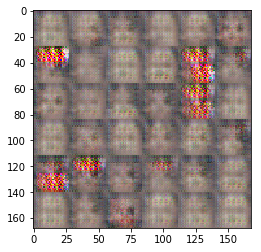

Epoch 0/1,  Step 1920	 Discriminator loss: 29.5848	 Generator loss: 38.6580	
Epoch 0/1,  Step 1940	 Discriminator loss: 12.9879	 Generator loss: 0.1425	
Epoch 0/1,  Step 1960	 Discriminator loss: 25.5332	 Generator loss: 69.5085	
Epoch 0/1,  Step 1980	 Discriminator loss: 7.5265	 Generator loss: 0.3679	
Epoch 0/1,  Step 2000	 Discriminator loss: 3.9315	 Generator loss: 0.6093	


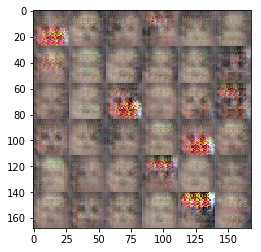

Epoch 0/1,  Step 2020	 Discriminator loss: 8.4596	 Generator loss: 0.0662	
Epoch 0/1,  Step 2040	 Discriminator loss: 9.2516	 Generator loss: 11.3525	
Epoch 0/1,  Step 2060	 Discriminator loss: 6.6738	 Generator loss: 0.3308	
Epoch 0/1,  Step 2080	 Discriminator loss: 5.1473	 Generator loss: 0.3034	
Epoch 0/1,  Step 2100	 Discriminator loss: 3.3990	 Generator loss: 3.1193	


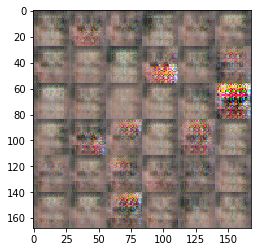

Epoch 0/1,  Step 2120	 Discriminator loss: 7.6543	 Generator loss: 1.3287	
Epoch 0/1,  Step 2140	 Discriminator loss: 5.6170	 Generator loss: 0.6291	
Epoch 0/1,  Step 2160	 Discriminator loss: 10.3295	 Generator loss: 0.6530	
Epoch 0/1,  Step 2180	 Discriminator loss: 6.7191	 Generator loss: 0.1829	
Epoch 0/1,  Step 2200	 Discriminator loss: 7.4195	 Generator loss: 0.2439	


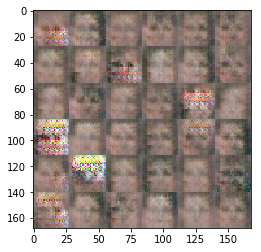

Epoch 0/1,  Step 2220	 Discriminator loss: 12.8215	 Generator loss: 0.0319	
Epoch 0/1,  Step 2240	 Discriminator loss: 4.8550	 Generator loss: 6.9731	
Epoch 0/1,  Step 2260	 Discriminator loss: 5.5362	 Generator loss: 0.3113	
Epoch 0/1,  Step 2280	 Discriminator loss: 7.3889	 Generator loss: 0.1839	
Epoch 0/1,  Step 2300	 Discriminator loss: 9.9117	 Generator loss: 14.1957	


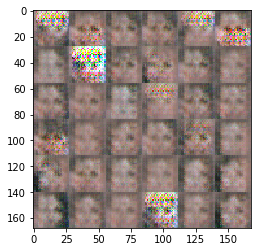

Epoch 0/1,  Step 2320	 Discriminator loss: 16.0279	 Generator loss: 19.4961	
Epoch 0/1,  Step 2340	 Discriminator loss: 4.0789	 Generator loss: 0.6492	
Epoch 0/1,  Step 2360	 Discriminator loss: 6.5548	 Generator loss: 9.3934	
Epoch 0/1,  Step 2380	 Discriminator loss: 9.2189	 Generator loss: 11.7552	
Epoch 0/1,  Step 2400	 Discriminator loss: 3.9031	 Generator loss: 6.1340	


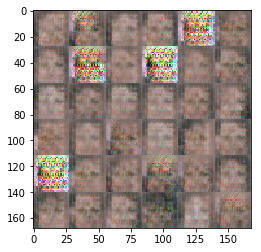

Epoch 0/1,  Step 2420	 Discriminator loss: 8.1661	 Generator loss: 11.6013	
Epoch 0/1,  Step 2440	 Discriminator loss: 7.4924	 Generator loss: 0.1050	
Epoch 0/1,  Step 2460	 Discriminator loss: 3.7736	 Generator loss: 0.4118	
Epoch 0/1,  Step 2480	 Discriminator loss: 5.3671	 Generator loss: 7.9594	
Epoch 0/1,  Step 2500	 Discriminator loss: 5.5003	 Generator loss: 6.4865	


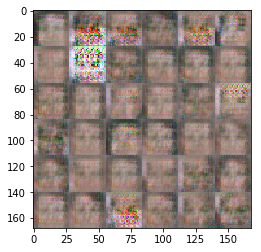

Epoch 0/1,  Step 2520	 Discriminator loss: 5.2077	 Generator loss: 0.1584	


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.